In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

In [4]:
comparison = pd.read_pickle('./performance_comparison.pck')
comparison.loc[comparison['Type'] == 'implicit', 'Type'] = 'complete'
#comparison = comparison[['Dataset', 'Model', 'Variable', 'Groundtruth', 'Prediction (mean)', 'Prediction (std)']]

In [3]:
dataset_parameters = comparison.columns[:4].tolist()
model_parameters = comparison.columns[4:9].tolist()
print(dataset_parameters, model_parameters)

['OTUs', 'Covariates', 'Data p0', 'Samples'] ['Type', 'Nu', 'Parametrization', 'Hyperprior', 'Model p0']


In [4]:
comparison.head()

,OTUs,Covariates,Data p0,Samples,Type,Nu,Parametrization,Hyperprior,Model p0,Dataset,Groundtruth,Model,Prediction (mean),Prediction (std),Variable
0,10,10,24,100,complete,,,,,10O_10C_24p0_100S,1.973648,implicit_complete,2.925892,0.065728,alpha
1,10,10,24,100,complete,,,,,10O_10C_24p0_100S,-1.654210,implicit_complete,-0.704210,0.126512,alpha
2,10,10,24,100,complete,,,,,10O_10C_24p0_100S,0.409291,implicit_complete,1.314408,0.081799,alpha
3,10,10,24,100,complete,,,,,10O_10C_24p0_100S,-1.643901,implicit_complete,-0.829684,0.134247,alpha
4,10,10,24,100,complete,,,,,10O_10C_24p0_100S,1.503907,implicit_complete,2.396395,0.068946,alpha


In [90]:
comparison['Dataset'].unique()

array(['10O_10C_24p0_100S', '280O_10C_12p0_50S', '80O_10C_12p0_100S',
       '80O_10C_12p0_150S', '150O_10C_12p0_50S', '50O_10C_12p0_150S',
       '5O_5C_6p0_25S', '80O_10C_12p0_200S', '5O_5C_6p0_150S',
       '5O_5C_6p0_100S', '10O_10C_24p0_150S', '20O_10C_12p0_25S',
       '20O_10C_12p0_150S', '80O_10C_12p0_50S', '280O_10C_12p0_200S',
       '150O_10C_12p0_150S', '280O_10C_12p0_100S', '50O_10C_12p0_100S',
       '10O_10C_24p0_5S', '50O_10C_12p0_25S', '10O_10C_24p0_50S',
       '150O_10C_12p0_100S', '150O_10C_12p0_200S', '10O_10C_24p0_25S',
       '50O_10C_12p0_200S', '20O_10C_12p0_200S', '50O_10C_12p0_50S',
       '20O_10C_12p0_100S', '5O_5C_6p0_50S', '20O_10C_12p0_50S',
       '5O_5C_6p0_5S', '280O_10C_12p0_150S'], dtype=object)

In [139]:
#selected = comparison[comparison['Model']=='horseshoe_nu1_noncentered_cauchy_p012']
#selected = selected[selected['Variable'] == 'beta']
selected = comparison.query('Model == "horseshoe_nu1_noncentered_cauchy_p012" and Variable == "alpha"'
                           'and Dataset == "50O_10C_12p0_200S"')
#selected
selected[['Groundtruth', 'Prediction (mean)']].sum()

Groundtruth         -7.634112
Prediction (mean)   -8.360399
dtype: float64

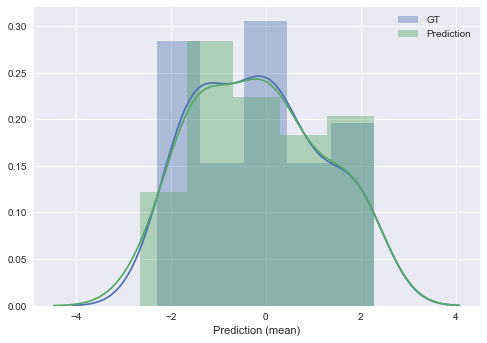

In [140]:
sns.distplot(selected.Groundtruth, label='GT')
sns.distplot(selected['Prediction (mean)'], label='Prediction')
sns.plt.legend()
sns.plt.show()

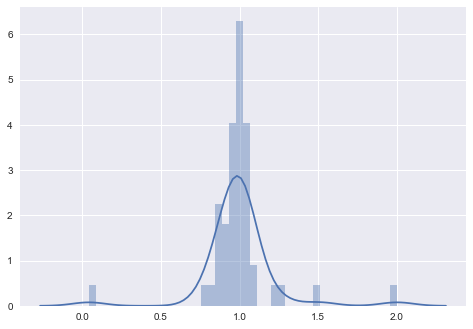

In [141]:
sns.distplot(selected.Groundtruth/selected['Prediction (mean)'])

## Compare complete models to horseshoe

In [5]:
def compute_statistics(data):
    correlation_coefficient, significance = pearsonr(data['Groundtruth'], data['Prediction (mean)'])
    mse = np.mean(np.power(data['Groundtruth'] - data['Prediction (mean)'], 2))
    return pd.Series({'Correlation': correlation_coefficient, 'Significance': significance, 'MSE': mse})

In [6]:
statistics = comparison.groupby(dataset_parameters + model_parameters + ['Variable'], as_index=False).apply(compute_statistics).reset_index()

NameError: name 'dataset_parameters' is not defined

In [7]:
statistics.head()

,OTUs,Covariates,Data p0,Samples,Type,Nu,Parametrization,Hyperprior,Model p0,Variable,Correlation,MSE,Significance
0,5,5,6,5,horseshoe,1,centered,cauchy,6,Relative Abundance,0.984724,0.000964,5.783719e-19
1,5,5,6,5,horseshoe,1,centered,cauchy,6,alpha,0.998573,10.232118,6.467576e-05
2,5,5,6,5,horseshoe,1,centered,cauchy,6,beta,0.886562,0.031123,3.664158e-09
3,5,5,6,5,horseshoe,1,centered,normal,6,Relative Abundance,0.982816,0.001085,2.218326e-18
4,5,5,6,5,horseshoe,1,centered,normal,6,alpha,0.998562,7.021824,6.544393e-05


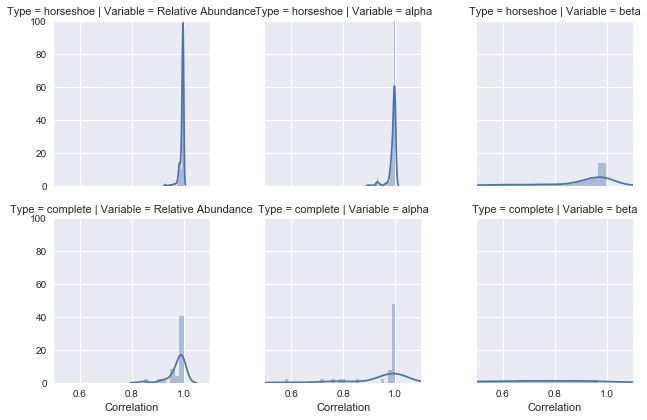

In [8]:
g = sns.FacetGrid(statistics,col='Variable', row='Type')
g.map(sns.distplot, 'Correlation')
g.set(ylim=(0, 100), xlim=(0.5, 1.1))

['complete' 3 1 2]


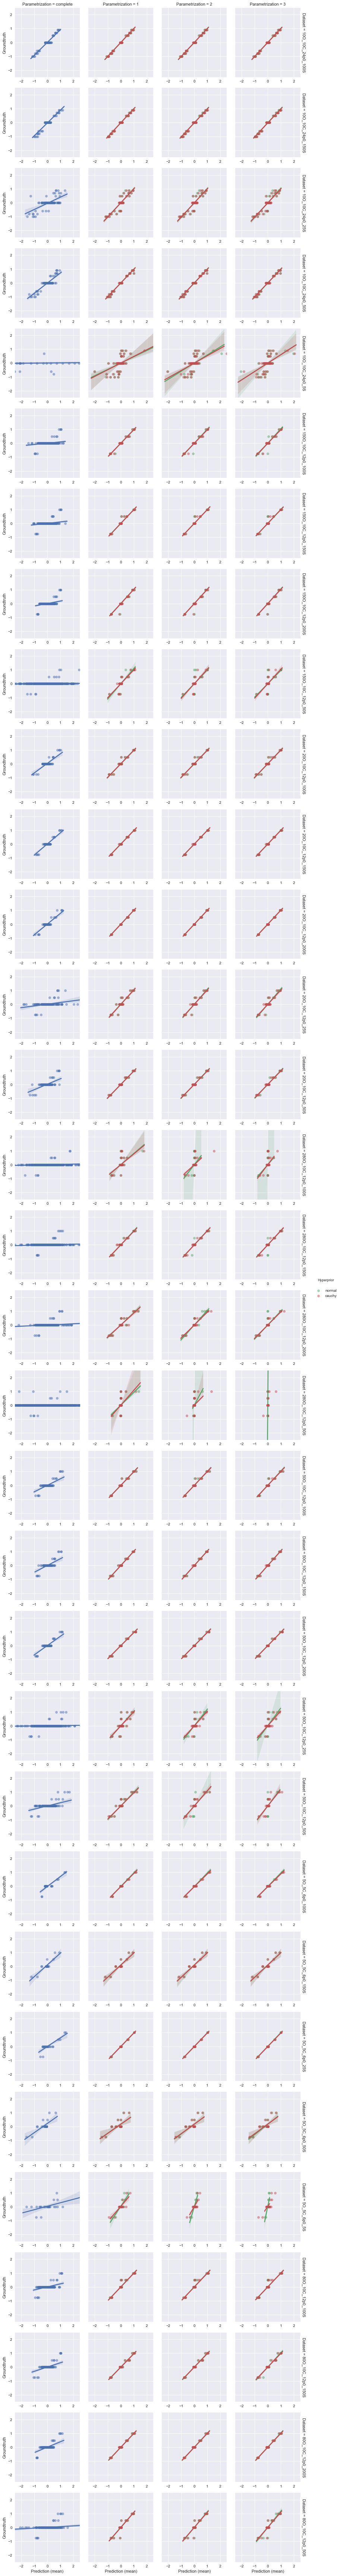

In [9]:
filtered = comparison[(comparison.Variable == 'beta') & ((comparison.Parametrization == 'noncentered') | (comparison.Parametrization == ''))  ].copy()
filtered.loc[filtered.Parametrization == '', 'Parametrization'] = 'complete'
horseshoe_runs = filtered.Parametrization == 'noncentered'
filtered.loc[horseshoe_runs, 'Parametrization'] = filtered.loc[horseshoe_runs, 'Nu']
print(filtered.Parametrization.unique())
#filtered['fraction'] = (filtered['OTUs']) / filtered['Samples']
filtered.sort_values('Dataset', inplace=True)
g = sns.FacetGrid(filtered, col='Parametrization', row='Dataset', hue='Hyperprior', margin_titles=True, col_order=['complete', 1, 2, 3], hue_order=['', 'normal', 'cauchy'], sharex=False, sharey=True,
                 legend_out=True)
g.map(sns.regplot, 'Prediction (mean)', 'Groundtruth', scatter_kws={'alpha':0.5})
g.set(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
g.add_legend()

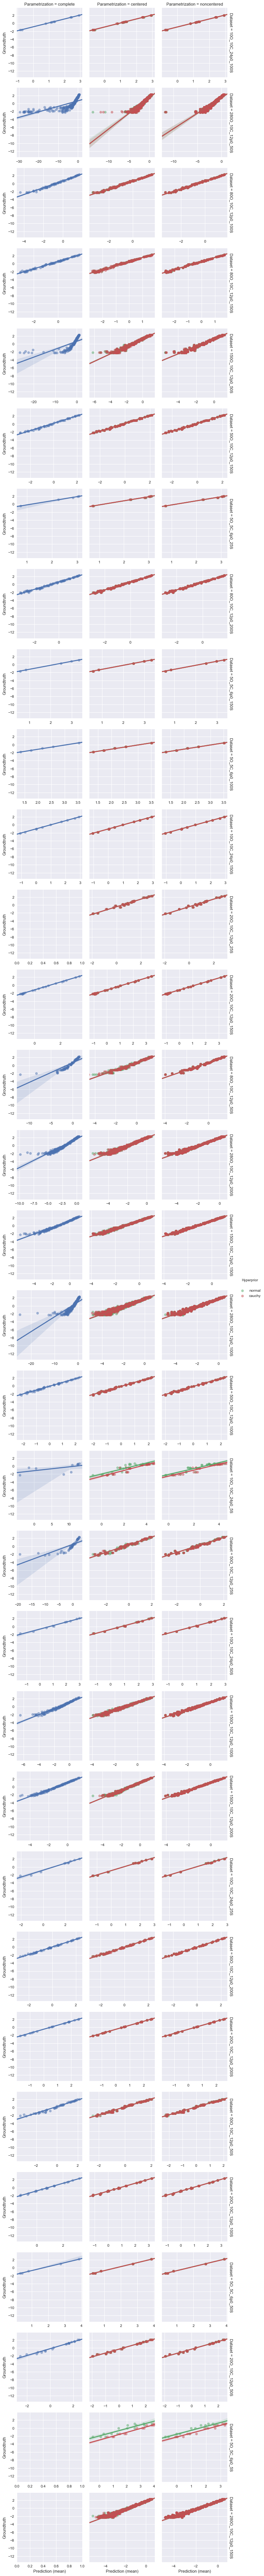

In [18]:
filtered = comparison[(comparison.Variable == 'alpha')].copy()
filtered.loc[filtered.Parametrization == '', 'Parametrization'] = 'complete'
g = sns.FacetGrid(filtered, col='Parametrization', row='Dataset', hue='Hyperprior', margin_titles=True, col_order=['complete', 'centered', 'noncentered'], sharex=False, sharey=True,
                 legend_out=True)
g.map(sns.regplot, 'Prediction (mean)', 'Groundtruth', scatter_kws={'alpha':0.5})
#g.set(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
g.add_legend()

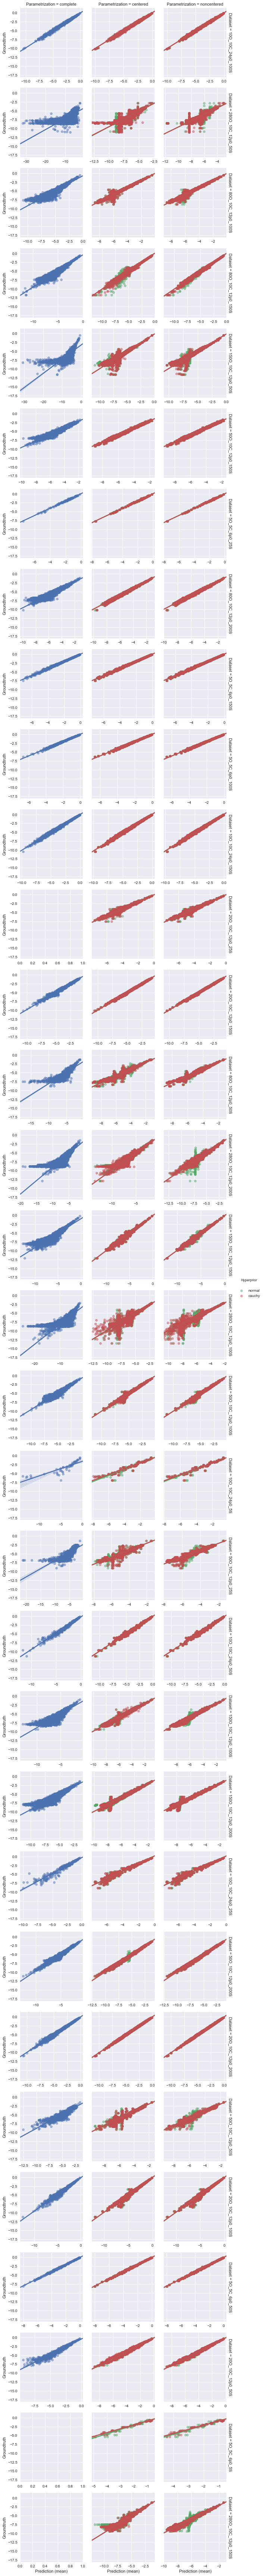

In [21]:
filtered = comparison[(comparison.Variable == 'Relative Abundance')].copy()
filtered.loc[filtered.Parametrization == '', 'Parametrization'] = 'complete'
filtered['Prediction (mean)'] = np.log(filtered['Prediction (mean)'])
filtered['Groundtruth'] = np.log(filtered['Groundtruth'])

g = sns.FacetGrid(filtered, col='Parametrization', row='Dataset', hue='Hyperprior', margin_titles=True, col_order=['complete', 'centered', 'noncentered'], sharex=False, sharey=True,
                 legend_out=True)
g.map(sns.regplot, 'Prediction (mean)', 'Groundtruth', scatter_kws={'alpha':0.5})
#g.set(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))
g.add_legend()

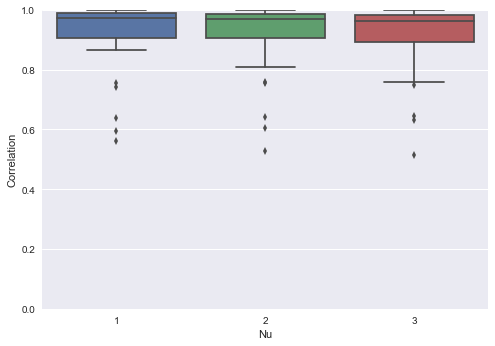

(0, 1)

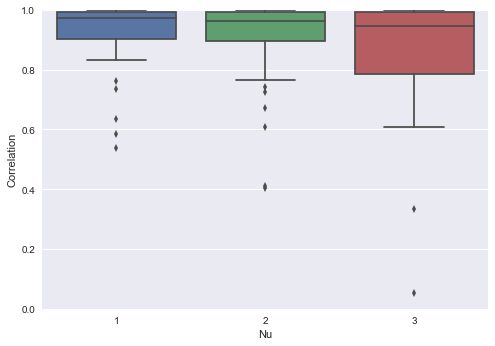

In [51]:
filtered = statistics[(statistics.Variable == 'beta') & (statistics.Parametrization == 'noncentered') & 
                      (statistics.Hyperprior == 'cauchy')].copy()
ax = sns.boxplot(data=filtered, x='Nu', y='Correlation')
ax.set_ylim((0, 1))
sns.plt.show()
filtered = statistics[(statistics.Variable == 'beta') & (statistics.Parametrization == 'noncentered') &
                     (statistics.Hyperprior == 'normal')].copy()
ax = sns.boxplot(data=filtered, x='Nu', y='Correlation')
ax.set_ylim((0, 1))

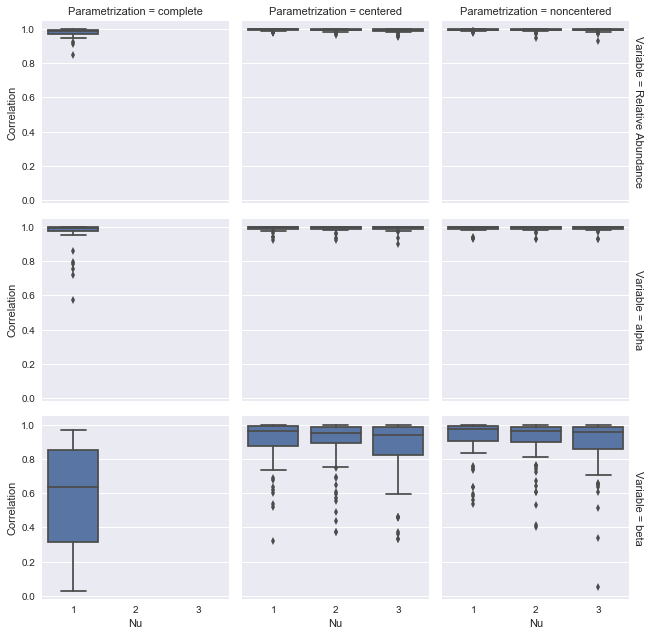

In [43]:
filtered = statistics.copy()
filtered.loc[filtered.Parametrization == '', 'Parametrization'] = 'complete'
g = sns.FacetGrid(data=filtered, row='Variable', col='Parametrization', col_order=['complete', 'centered', 'noncentered'], margin_titles=True)
g.map(sns.boxplot, 'Nu', 'Correlation')

### Lets look at the sampling statistics

In [24]:
sampler_stats = pd.read_pickle('./sampler_statistics.pck')
sampler_stats.head()

,OTUs,Covariates,Data p0,Samples,Type,Nu,Parametrization,Hyperprior,Model p0,Dataset,Model,depth,diverging,mean_tree_accept,step_size,tree_size
0,10,10,24,100,implicit,,,,,10O_10C_24p0_100S,implicit_complete,6.0025,0,0.893879,0.123288,71.152
1,10,10,24,100,horseshoe,3,noncentered,normal,24,10O_10C_24p0_100S,horseshoe_nu3_noncentered_normal_p024,7.7785,17,0.901648,0.023749,226.441
2,10,10,24,100,horseshoe,3,noncentered,cauchy,24,10O_10C_24p0_100S,horseshoe_nu3_noncentered_cauchy_p024,8.0000,1,0.914086,0.014421,254.978
3,10,10,24,100,horseshoe,2,centered,normal,24,10O_10C_24p0_100S,horseshoe_nu2_centered_normal_p024,5.6610,1061,0.514782,0.012436,168.104
4,10,10,24,100,horseshoe,1,noncentered,normal,24,10O_10C_24p0_100S,horseshoe_nu1_noncentered_normal_p024,8.9160,201,0.904498,0.008916,486.103


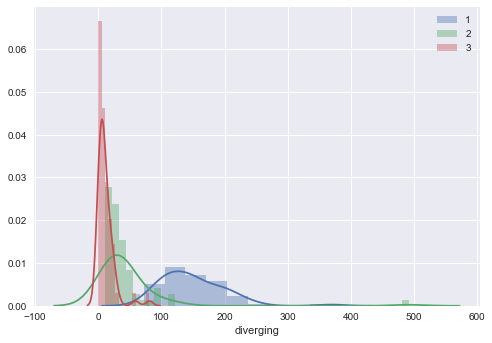

In [34]:
filtered = sampler_stats[sampler_stats.Parametrization == 'noncentered']
for i in range(1, 4):
    sns.distplot(filtered.loc[filtered['Nu'] == i, 'diverging'], label=str(i))
sns.plt.legend()

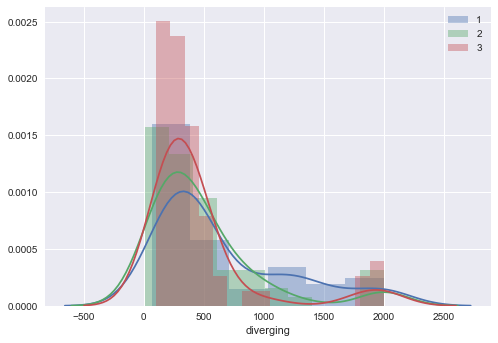

In [30]:
filtered = sampler_stats[sampler_stats.Parametrization == 'centered']
for i in range(1, 4):
    sns.distplot(filtered.loc[filtered['Nu'] == i, 'diverging'], label=str(i))
sns.plt.legend()

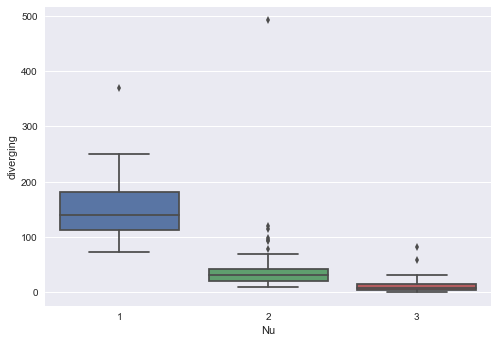

In [29]:
filtered = sampler_stats[sampler_stats.Parametrization == 'centered']
sns.boxplot(data=filtered, x='Nu', y='diverging')

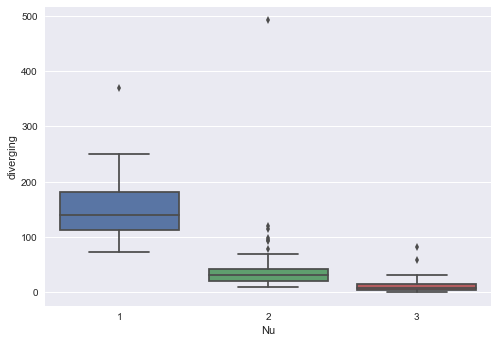

In [52]:
filtered = sampler_stats[sampler_stats.Parametrization == 'noncentered']
sns.boxplot(data=filtered, x='Nu', y='diverging')

In [88]:
def match_horseshoe_to_complete(data):
    dataset = data['Dataset'].unique()[0]
    explicit = data['Explicit'].unique()[0]
    res = None
    
    complete_model = data[data['type']=='complete']
    complete_model.set_index('Variable', inplace=True)
    complete_model_correlations = complete_model['Correlation']
    print(complete_model_correlations)
    non_complete_models = data[data['type']!='complete']
    if len(complete_model_correlations) == 0:
        return 
    
    for (model, var), data in non_complete_models.groupby(['Model', 'Variable']):
        parameters = data.iloc[0, :][model_parameters]
        combined = parameters.append(
            pd.Series([var, data.iloc[0, :]['Correlation'], complete_model_correlations[var]],
                      index=['Variable', 'horseshoe correlation', 'complete correlation'])
        )#.append(parameters)
        #combined.name=(dataset, model, var)
        #res.columns = combined.index
        #print('Res:', res)
        #print('Combined:', combined)
        if res is None:
            res = combined.to_frame().T
        else:
            res = res.append(combined, ignore_index=True)
    return res
    

In [91]:
grouped_correlations = correlations.groupby(['Dataset', 'type'], as_index=False).apply(match_horseshoe_to_complete)

Variable
Relative Abundance    0.995549
alpha                 0.999351
beta                  0.963066
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.995549
alpha                 0.999351
beta                  0.963066
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.728237
alpha                 0.922092
beta                  0.576797
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.998601
alpha                 0.999576
beta                  0.956229
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.728797
alpha                 0.890778
beta                  0.596111
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.973690
alpha                 0.993220
beta                  0.299525
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.662382
alpha                 0.959815
beta                  0.314783
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.993878
alpha   

Variable
Relative Abundance    0.769947
alpha                 0.962919
beta                  0.452558
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.956972
alpha                 0.945394
beta                  0.274020
Name: Correlation, dtype: float64
Variable
Relative Abundance    0.607416
alpha                 0.931079
beta                  0.190848
Name: Correlation, dtype: float64


In [92]:
grouped_correlations

Explicit       type nu parametrization Model p0            Dataset  \
0  0     False  horseshoe  1        centered       24  10O_10C_24p0_100S   
   1     False  horseshoe  1        centered       24  10O_10C_24p0_100S   
   2     False  horseshoe  1        centered       24  10O_10C_24p0_100S   
   3     False  horseshoe  1        centered       48  10O_10C_24p0_100S   
   4     False  horseshoe  1        centered       48  10O_10C_24p0_100S   
   5     False  horseshoe  1        centered       48  10O_10C_24p0_100S   
   6     False  horseshoe  1        centered       72  10O_10C_24p0_100S   
   7     False  horseshoe  1        centered       72  10O_10C_24p0_100S   
   8     False  horseshoe  1        centered       72  10O_10C_24p0_100S   
   9     False  horseshoe  1        centered       96  10O_10C_24p0_100S   
   10    False  horseshoe  1        centered       96  10O_10C_24p0_100S   
   11    False  horseshoe  1        centered       96  10O_10C_24p0_100S   
   12    False  horseshoe  2        centered       24  10O_10C_24p0_100S   
   13    False  horseshoe  2        centered       24  10O_10C_24p0_100S   
   14    False  horseshoe  2        centered       24  10O_10C_24p0_100S   
   15    False  horseshoe  2        centered       48  10O_10C_24p0_100S   
   16    False  horseshoe  2        centered       48  10O_10C_24p0_100S   
   17    False  horseshoe  2        centered       48  10O_10C_24p0_100S   
   18    False  horseshoe  2        centered       72  10O_10C_24p0_100S   
   19    False  horseshoe  2        centered       72  10O_10C_24p0_100S   
   20    False  horseshoe  2        centered       72  10O_10C_24p0_100S   
   21    False  horseshoe  2        centered       96  10O_10C_24p0_100S   
   22    False  horseshoe  2        centered       96  10O_10C_24p0_100S   
   23    False  horseshoe  2        centered       96  10O_10C_24p0_100S   
   24    False  horseshoe  2     noncentered       24  10O_10C_24p0_100S   
   25    False  horseshoe  2     noncentered       24  10O_10C_24p0_100S   
   26    False  horseshoe  2     noncentered       24  10O_10C_24p0_100S   
   27    False  horseshoe  2     noncentered       48  10O_10C_24p0_100S   
   28    False  horseshoe  2     noncentered       48  10O_10C_24p0_100S   
   29    False  horseshoe  2     noncentered       48  10O_10C_24p0_100S   
...        ...        ... ..             ...      ...                ...   
63 30     True  horseshoe  2     noncentered       36   80O_10C_12p0_50S   
   31     True  horseshoe  2     noncentered       36   80O_10C_12p0_50S   
   32     True  horseshoe  2     noncentered       36   80O_10C_12p0_50S   
   33     True  horseshoe  2     noncentered       48   80O_10C_12p0_50S   
   34     True  horseshoe  2     noncentered       48   80O_10C_12p0_50S   
   35     True  horseshoe  2     noncentered       48   80O_10C_12p0_50S   
   36     True  horseshoe  3        centered       12   80O_10C_12p0_50S   
   37     True  horseshoe  3        centered       12   80O_10C_12p0_50S   
   38     True  horseshoe  3        centered       12   80O_10C_12p0_50S   
   39     True  horseshoe  3        centered       24   80O_10C_12p0_50S   
   40     True  horseshoe  3        centered       24   80O_10C_12p0_50S   
   41     True  horseshoe  3        centered       24   80O_10C_12p0_50S   
   42     True  horseshoe  3        centered       36   80O_10C_12p0_50S   
   43     True  horseshoe  3        centered       36   80O_10C_12p0_50S   
   44     True  horseshoe  3        centered       36   80O_10C_12p0_50S   
   45     True  horseshoe  3        centered       48   80O_10C_12p0_50S   
   46     True  horseshoe  3        centered       48   80O_10C_12p0_50S   
   47     True  horseshoe  3        centered       48   80O_10C_12p0_50S   
   48     True  horseshoe  3     noncentered       12   80O_10C_12p0_50S   
   49     True  horseshoe  3     noncentered       12   80O_10C_12p0_50S   
   50     True  horseshoe  3     noncentered       12 

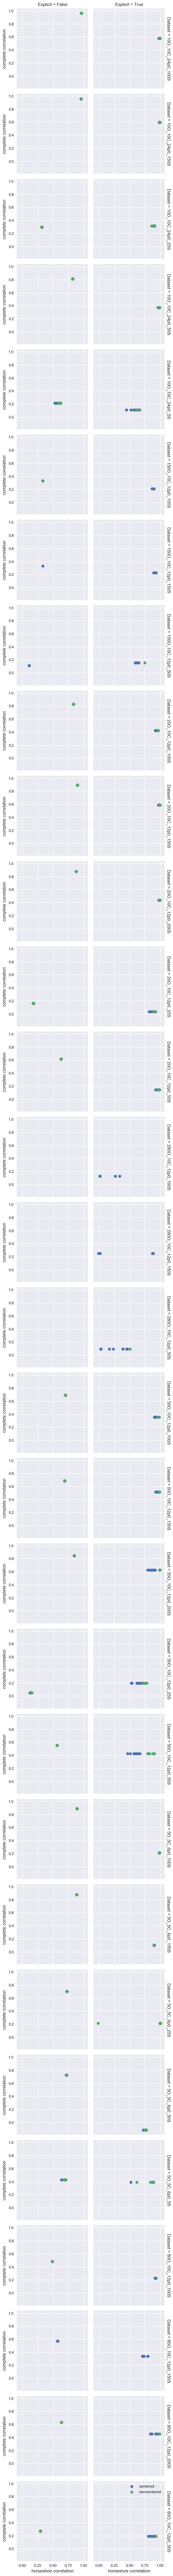

In [97]:
beta_values = grouped_correlations[grouped_correlations['Variable'] == 'beta']
g = sns.FacetGrid(beta_values, row='Dataset', col='Explicit', hue='parametrization', margin_titles=True)
g.map(sns.plt.scatter, 'horseshoe correlation', 'complete correlation')
g.set()
sns.plt.legend()

In [18]:
centered_datasets = correlations[correlations['parametrization'] == 'centered']
noncentered_datasets = correlations[correlations['parametrization'] == 'noncentered']

In [23]:
def plot_variable_vs_identifyability(totaldataset, variable):
    dataset = totaldataset[totaldataset['Variable'] == variable]
    sns.plt.scatter(dataset['Samples']/(dataset['Covariates']*dataset['OTUs']), dataset['Correlation'])

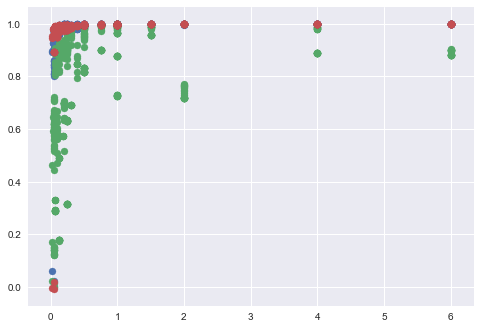

In [30]:
plot_variable_vs_identifyability(centered_datasets, 'alpha')
plot_variable_vs_identifyability(centered_datasets, 'beta')
plot_variable_vs_identifyability(centered_datasets, 'Relative Abundance')

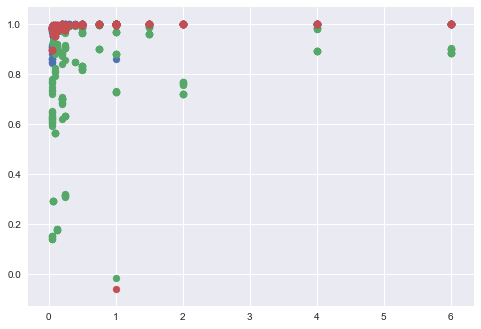

In [29]:
plot_variable_vs_identifyability(noncentered_datasets, 'alpha')
plot_variable_vs_identifyability(noncentered_datasets, 'beta')
plot_variable_vs_identifyability(noncentered_datasets, 'Relative Abundance')

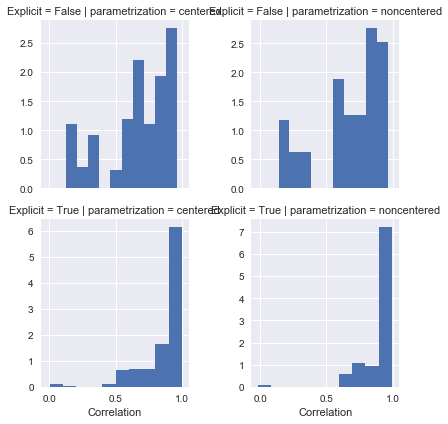

In [50]:
reduced = correlations[correlations['Variable'] == 'beta']
g = sns.FacetGrid(reduced, col='parametrization', row='Explicit', sharey=False)
g.map(sns.plt.hist, 'Correlation', normed=True)

In [ ]:
reduced = comparison_datasplitted[comparison_datasplitted['Variable'] == 'beta']
g = sns.FacetGrid(reduced, row='Explicit', col='nu')


In [57]:
data = comparison_datasplitted
centered_nu1 = correlations[((correlations['nu'] == 1.0) | pd.isnull(correlations['nu'])) &
                            (correlations['parametrization'] != 'noncentered') & 
                            ((correlations['Data p0'] == correlations['Model p0']) | pd.isnull(correlations['Model p0']))]
(correlations['type'] == 'complete').sum()
#centered_nu1.groupby(dataset_parameters + ['Explicit']).apply()

0

In [51]:
beta_and_nu = comparison_datasplitted[
    np.logical_and(comparison_datasplitted['Variable'] == 'beta', ~pd.isnull(comparison_datasplitted['nu']))]
beta_and_nu
#sns.plt.scatter(comparison)

,OTUs,Covariates,Data p0,Samples,Explicit,type,nu,parametrization,Model p0,Variable,Groundtruth,Prediction (mean),Prediction (std)
1120,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,-0.6,-0.538768,0.002401
1121,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,-0.8,-0.663905,0.003422
1122,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,0.9,0.862055,0.004139
1123,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,-1.0,-0.792905,0.004279
1124,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,0.7,0.792430,0.001391
1125,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,0.5,0.527766,0.001896
1126,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,0.0,0.000127,0.000905
1127,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,0.0,-0.011375,0.001037
1128,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,0.0,0.044883,0.001314
1129,10,10,24,100,True,horseshoe,1.0,centered,24.0,beta,0.0,0.106166,0.004656
